# Socrata Query Language (SoQL) Clauses and Functions
Mark Bauer

Table of Contents
=================

   1. Introduction
   2. Socrata Open Data
       * 2.1 Using Socrata Open Data API (SODA)
       * 2.2 Using Sodapy
       * 2.3 Socrata Query Language or "SoQL"
   3. Importing Libraries
   4. SoQL with Sodapy
       * 4.1 SoQL Clauses
       * 4.2 SoQL Function and Keyword Listing
   5. Answering Questions about NYC 311 Complaints with SoQL
   6. Retrieving Data Directly from Socrata Open Data API (SODA)    
   7. Conclusion

# 1. Introduction  
This notebook demonstrates basic queries using SoQL, the Socrata Query Language. 

# 2. Socrata Open Data

## 2.1 Socrata Open Data API (SODA)

More information can be found on the offical [Socrata Open Data API (SODA)](https://dev.socrata.com/) website. We use sodapy, a python client, to interact with the Socrata Open Data API.

There's a lot of great resources on the website, and I encourage you to read through the [API Docs](https://dev.socrata.com/docs/endpoints.html) to further your understanding.

![dev socrata](images/dev-socrata.png)

Source: https://dev.socrata.com/

## 2.2 Sodapy

Sodapy - a python client for the Socrata Open Data API.
Information about sodapy can be found in its offical docs on [GitHub](https://github.com/xmunoz/sodapy), as well as my notebook tutorial in this project here [sodapy-basics.ipynb](https://github.com/mebauer/sodapy-tutorial-nyc-open-data/blob/main/sodapy-basics.ipynb).


In order use sodapy, a **source domain** (i.e. the open data source you are trying to connect to) needs to be passed to the Socrata class. Additionally, if a user wants to query a specific dataset, then the **dataset identifier** (i.e. the dataset id on the given source domain) needs to be passed as well. Below, we identify NYC Open Data's source domain `data.cityofnewyork.us` and the dataset identifier for the NYC 311 data set `erm2-nwe9`. The screenshot is the homepage of the 311 data set from NYC Open Data.

![nyc-311-api-docs](images/nyc-311-api-docs.png)  

Source: https://dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9

## 2.3 Socrata Query Language or "SoQl"

![soql screenshot](images/soql-screenshot.png)

Source: https://dev.socrata.com/docs/queries/

# 3. Importing Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import urllib.parse

sns.set_theme()
plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
## documention for installing watermark: https://github.com/rasbt/watermark
%reload_ext watermark
%watermark -t -d -v -p pandas,sodapy

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

pandas: 1.4.2
sodapy: 2.2.0



# 5. Answering Questions about NYC 311 Complaints with SoQL

## Most NYC 311 Complaints by Complaint Type

In [3]:
# Source domain for NYC Open Data on Socrata
socrata_domain = 'data.cityofnewyork.us'

# Data set id for NYC 311 on NYC Open Data on Socrata
socrata_dataset_identifier = 'erm2-nwe9'

# Socrata - The main class that interacts with the SODA API. We pass the source domain value
# of NYC Open data, the app token as 'None', and set the timeout parameter for '1,000 seconds'
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the complaint_type and the count of complaint_type columns 
grouped by complaint_type, sorted by the count of complaint_type in descending order
and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type, 
    count(unique_key) AS count
GROUP BY 
    complaint_type
ORDER BY 
    count DESC
LIMIT 
    1000
"""

# Requesting data from the NYC 311 data set
# and passing our query as a full SoQL query string
results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (485, 2)


,complaint_type,count
0,Noise - Residential,3111372
1,Illegal Parking,2074088
2,HEAT/HOT WATER,1980665
3,Blocked Driveway,1427768
4,Street Condition,1207375
5,Street Light Condition,1113630
6,Noise - Street/Sidewalk,1084608
7,Request Large Bulky Item Collection,1073753
8,HEATING,887869
9,PLUMBING,886038


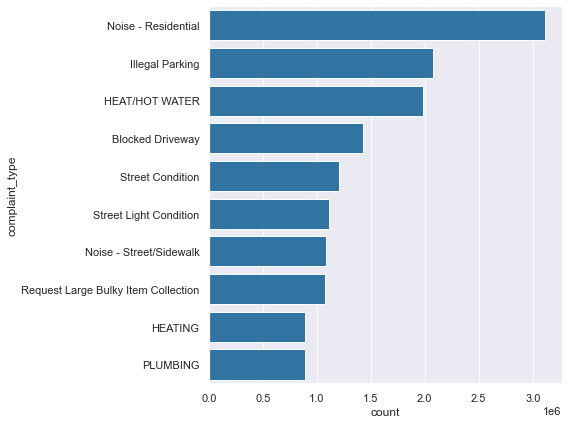

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

results_df['count'] = results_df['count'].astype(int)

data = (
    results_df
    .sort_values(by='count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='complaint_type',
    x='count',
    color='#1f77b4'
)

plt.tight_layout()

In [5]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the complaint_type and the count of complaint_type columns 
grouped by complaint_type, sorted by the count of complaint_type in descending order
and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type, 
    descriptor,
    count(unique_key) AS count
GROUP BY 
    complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (1000, 3)


,complaint_type,descriptor,count
0,Noise - Residential,Loud Music/Party,2081892
1,HEAT/HOT WATER,ENTIRE BUILDING,1292405
2,Request Large Bulky Item Collection,Request Large Bulky Item Collection,1073753
3,Blocked Driveway,No Access,1066161
4,HEATING,HEAT,868960
5,Noise - Street/Sidewalk,Loud Music/Party,846234
6,Street Light Condition,Street Light Out,820644
7,Noise - Residential,Banging/Pounding,789766
8,Street Condition,Pothole,731729
9,HEAT/HOT WATER,APARTMENT ONLY,688260


## Most NYC 311 Complaints by Day

In [6]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day, 
    count(unique_key) AS count
GROUP BY 
    day
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (1000, 2)


,day,count
0,2020-08-04T00:00:00.000,24415
1,2020-08-05T00:00:00.000,19560
2,2020-07-05T00:00:00.000,16916
3,2020-06-21T00:00:00.000,15883
4,2020-06-20T00:00:00.000,15825
5,2020-07-04T00:00:00.000,15794
6,2021-09-02T00:00:00.000,15205
7,2020-06-28T00:00:00.000,14057
8,2021-10-28T00:00:00.000,13575
9,2020-08-06T00:00:00.000,13288


In [7]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2020-08-04T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (455, 4)


,day,complaint_type,descriptor,count
0,2020-08-04T00:00:00.000,Damaged Tree,Entire Tree Has Fallen Down,7848
1,2020-08-04T00:00:00.000,Damaged Tree,Branch or Limb Has Fallen Down,4971
2,2020-08-04T00:00:00.000,Damaged Tree,Branch Cracked and Will Fall,1330
3,2020-08-04T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,909
4,2020-08-04T00:00:00.000,Noise - Residential,Loud Music/Party,762
5,2020-08-04T00:00:00.000,Damaged Tree,Tree Leaning/Uprooted,510
6,2020-08-04T00:00:00.000,Street Light Condition,Street Light Out,397
7,2020-08-04T00:00:00.000,Traffic Signal Condition,Controller,353
8,2020-08-04T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,263
9,2020-08-04T00:00:00.000,Blocked Driveway,No Access,259


In [8]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2020-07-05T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (330, 4)


,day,complaint_type,descriptor,count
0,2020-07-05T00:00:00.000,Noise - Residential,Loud Music/Party,4334
1,2020-07-05T00:00:00.000,Illegal Fireworks,N/A,4199
2,2020-07-05T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,2837
3,2020-07-05T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,752
4,2020-07-05T00:00:00.000,Noise - Vehicle,Car/Truck Music,412
5,2020-07-05T00:00:00.000,Noise - Residential,Banging/Pounding,304
6,2020-07-05T00:00:00.000,Non-Emergency Police Matter,Social Distancing,239
7,2020-07-05T00:00:00.000,Blocked Driveway,No Access,206
8,2020-07-05T00:00:00.000,Noise - Commercial,Loud Music/Party,189
9,2020-07-05T00:00:00.000,Water System,Hydrant Running Full (WA4),188


## Analyzing NYC 311 Datasets with the Most Downloads

In [9]:
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

# Reading in a list of dictionaries of our data into a pandas DataFrame
df = pd.DataFrame.from_records(client.datasets())
client.close()

print(df.shape)
df.head()

(3526, 8)


,resource,classification,metadata,permalink,link,owner,creator,preview_image_url
0,"{'name': 'Civil Service List (Active)', 'id': ...","{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/vx8i-nprf,https://data.cityofnewyork.us/City-Government/...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
1,"{'name': 'DOB Job Application Filings', 'id': ...","{'categories': ['economy', 'environment', 'hou...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/ic3t-wcy2,https://data.cityofnewyork.us/Housing-Developm...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
2,"{'name': 'TLC New Driver Application Status', ...","{'categories': ['transportation', 'environment...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/dpec-ucu7,https://data.cityofnewyork.us/Transportation/T...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
3,"{'name': 'For Hire Vehicles (FHV) - Active', '...","{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/8wbx-tsch,https://data.cityofnewyork.us/Transportation/F...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
4,{'name': 'For Hire Vehicles (FHV) - Active Dri...,"{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/xjfq-wh2d,https://data.cityofnewyork.us/Transportation/F...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN


In [10]:
# Reading the dictionary in the resource column into a pandas DataFrame
df = pd.DataFrame.from_records(df.resource)

print(df.shape)
df.head()

(3526, 25)


,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,columns_datatype,columns_description,columns_format,download_count,provenance,lens_view_type,lens_display_type,blob_mime_type,hide_from_data_json,publication_date
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-07T13:34:17.000Z,2016-06-14T21:12:15.000Z,...,"[Number, Text, Text, Text, Text, Text, Text, C...",[An eligible candidate’s placement on a given ...,"[{'precisionStyle': 'standard', 'noCommas': 'f...",52604,official,tabular,table,None,False,2023-07-07T13:34:17.000Z
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-07T20:03:22.000Z,2013-04-18T15:18:56.000Z,...,"[Number, Text, Text, Text, Text, Text, Text, T...","[Street Frontage, Equipment Work Type? (X=Yes...","[{'precisionStyle': 'standard', 'noCommas': 't...",37213,official,tabular,table,None,False,2020-06-22T18:23:35.000Z
2,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-08T16:03:22.000Z,2016-05-17T18:43:43.000Z,...,"[Calendar date, Calendar date, Text, Text, Num...","[Latest Updated Date\n, The date you submitted...","[{'view': 'date_time', 'align': 'left'}, {'vie...",35485,official,tabular,table,None,False,2019-12-17T18:44:57.000Z
3,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-07T19:02:11.000Z,2015-07-16T17:33:32.000Z,...,"[Text, Text, Number, Text, Text, Calendar date...","[Reason Code A,B,C or G\n, Base Website, Vehic...","[{'displayStyle': 'plain', 'align': 'left'}, {...",256759,official,tabular,table,None,False,2021-04-05T13:20:47.000Z
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-07T19:02:31.000Z,2015-07-16T17:24:02.000Z,...,"[Calendar date, Text, Text, Text, Text, Calend...","[Expiration Date\n\n\n, Last Time Updated, Dri...","[{'view': 'date', 'align': 'left'}, {'displayS...",224307,official,tabular,table,None,False,2023-07-07T19:02:31.000Z


In [11]:
(df
 .groupby(by='attribution')['name']
 .count()
 .sort_values(ascending=False)
 .head(20)
)

attribution
NYC Department of Education                                 543
Department of Education (DOE)                               257
Office of Technology and Innovation (OTI)                   214
Department of Transportation (DOT)                          186
Department of Parks and Recreation (DPR)                    180
Department of Education                                     166
Department of City Planning (DCP)                           132
Department of Finance (DOF)                                 105
Taxi and Limousine Commission (TLC)                          70
Department of Youth and Community Development (DYCD)         49
Department of Probation (DOP)                                46
Mayor's Office of Management and Budget (OMB)                45
Mayor's Office of Contract Services (MOCS)                   45
Mayor's Office of Climate and Sustainability                 43
Department of Environmental Protection (DEP)                 42
Department of Health and Men

In [12]:
# Sorting the data sets by download_count
(df
 .loc[:, ['attribution', 'name', 'download_count']]
 .sort_values(by='download_count', ascending=False)
 .head(10)
)

,attribution,name,download_count
43,Department of Youth and Community Development ...,Demographic Statistics By Zip Code,1017553
1240,Department of Transportation (DOT),Overhead Electronic Signs,429596
6,"311, DoITT",311 Service Requests from 2010 to Present,398678
9,Taxi and Limousine Commission (TLC),Medallion Drivers - Active,288920
63,Board of Elections (BOENY),Voting/Poll Sites Map,262653
3,Taxi and Limousine Commission (TLC),For Hire Vehicles (FHV) - Active,256759
328,NYC Emergency Management (NYCEM),Hurricane Evacuation Centers (Map),230876
4,Taxi and Limousine Commission (TLC),For Hire Vehicles (FHV) - Active Drivers,224307
11,Metropolitan Transportation Authority (MTA),Subway Entrances,222219
35,Department of City Planning (DCP),Police Precincts,215519


In [13]:
(df
 .groupby(by='attribution')['download_count']
 .sum()
 .sort_values(ascending=False)
 .head(20)
)

attribution
Department of Youth and Community Development (DYCD)     1156799
Taxi and Limousine Commission (TLC)                      1094762
Department of City Planning (DCP)                         941002
Department of Transportation (DOT)                        659515
Department of Education (DOE)                             566533
Department of Finance (DOF)                               519789
Office of Technology and Innovation (OTI)                 422682
311, DoITT                                                403026
Department of Citywide Administrative Services (DCAS)     341408
Department of Health and Mental Hygiene (DOHMH)           323215
Department of Homeless Services (DHS)                     301129
Metropolitan Transportation Authority (MTA)               300813
NYC Department of Education                               295185
Police Department (NYPD)                                  272527
Board of Elections (BOENY)                                270917
Department of

In [14]:
(df
 .groupby(by='attribution')['download_count']
 .mean()
 .sort_values(ascending=False)
 .round(0)
 .astype(int)
 .head(20)
)

attribution
Board of Elections (BOENY)                                           90306
Metropolitan Transportation Authority (MTA)                          75203
NYC Management Department (NYCEM)                                    41530
311, DoITT                                                           33586
Department of Youth and Community Development (DYCD)                 23608
NYC Emergency Management (NYCEM)                                     19589
Broadway Theater                                                     18530
Office of Payroll Administration (OPA)                               16630
Taxi and Limousine Commission (TLC)                                  15639
Department of Information Technology & Telecommunications (DoITT)    14695
Department of Homeless Services (DHS)                                13688
Office of Administrative Trials and Hearings (OATH)                  11608
Department of Citywide Administrative Services (DCAS)                11013
Mayor’s Offic

In [15]:
(df
 .groupby(by='attribution')['download_count']
 .median()
 .sort_values(ascending=False)
 .round(0)
 .astype(int)
 .head(20)
)

attribution
NYC Management Department (NYCEM)                                    41530
Metropolitan Transportation Authority (MTA)                          32464
Broadway Theater                                                     18530
Office of Payroll Administration (OPA)                               16630
Office of Administrative Trials and Hearings (OATH)                  11608
Mayor’s Office of Media and Entertainment (MOME)                     10774
Office of the Mayor (OTM)                                            10405
Department of Edcuation                                               9596
Department of Mental Health and Hygeine                               8598
Department of Information Technology & Telecommunications (DoITT)     8020
Board of Elections (BOENY)                                            6940
Business Integrity Commission                                         6006
Department of Buildings (DOB)                                         5133
NYC Service (

## Analyzing NYC 311 Data Sets with the Most Page Views

In [16]:
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

In [17]:
# Reading in a list of dictionaries of our data into a pandas DataFrame
df = pd.DataFrame.from_records(client.datasets())
client.close()

df = pd.DataFrame.from_records(df.resource)

print(df.shape)
df.head()

(3526, 25)


,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,columns_datatype,columns_description,columns_format,download_count,provenance,lens_view_type,lens_display_type,blob_mime_type,hide_from_data_json,publication_date
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-07T13:34:17.000Z,2016-06-14T21:12:15.000Z,...,"[Number, Text, Text, Text, Text, Text, Text, C...",[An eligible candidate’s placement on a given ...,"[{'precisionStyle': 'standard', 'noCommas': 'f...",52604,official,tabular,table,None,False,2023-07-07T13:34:17.000Z
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-07T20:03:22.000Z,2013-04-18T15:18:56.000Z,...,"[Number, Text, Text, Text, Text, Text, Text, T...","[Street Frontage, Equipment Work Type? (X=Yes...","[{'precisionStyle': 'standard', 'noCommas': 't...",37213,official,tabular,table,None,False,2020-06-22T18:23:35.000Z
2,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-08T16:03:22.000Z,2016-05-17T18:43:43.000Z,...,"[Calendar date, Calendar date, Text, Text, Num...","[Latest Updated Date\n, The date you submitted...","[{'view': 'date_time', 'align': 'left'}, {'vie...",35485,official,tabular,table,None,False,2019-12-17T18:44:57.000Z
3,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-07T19:02:11.000Z,2015-07-16T17:33:32.000Z,...,"[Text, Text, Number, Text, Text, Calendar date...","[Reason Code A,B,C or G\n, Base Website, Vehic...","[{'displayStyle': 'plain', 'align': 'left'}, {...",256759,official,tabular,table,None,False,2021-04-05T13:20:47.000Z
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-07T19:02:31.000Z,2015-07-16T17:24:02.000Z,...,"[Calendar date, Text, Text, Text, Text, Calend...","[Expiration Date\n\n\n, Last Time Updated, Dri...","[{'view': 'date', 'align': 'left'}, {'displayS...",224307,official,tabular,table,None,False,2023-07-07T19:02:31.000Z


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3526 entries, 0 to 3525
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 3526 non-null   object
 1   id                   3526 non-null   object
 2   parent_fxf           3526 non-null   object
 3   description          3526 non-null   object
 4   attribution          3312 non-null   object
 5   attribution_link     408 non-null    object
 6   contact_email        0 non-null      object
 7   type                 3526 non-null   object
 8   updatedAt            3526 non-null   object
 9   createdAt            3526 non-null   object
 10  metadata_updated_at  3526 non-null   object
 11  data_updated_at      3301 non-null   object
 12  page_views           3526 non-null   object
 13  columns_name         3526 non-null   object
 14  columns_field_name   3526 non-null   object
 15  columns_datatype     3526 non-null   object
 16  column

In [19]:
df['page_views'].head()

0    {'page_views_last_week': 4001, 'page_views_las...
1    {'page_views_last_week': 413, 'page_views_last...
2    {'page_views_last_week': 122, 'page_views_last...
3    {'page_views_last_week': 6670, 'page_views_las...
4    {'page_views_last_week': 2365, 'page_views_las...
Name: page_views, dtype: object

In [20]:
df = pd.concat(
    [df.drop(['page_views'], axis=1), df['page_views'].apply(pd.Series)],
    axis=1
)

df.head()

,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,lens_display_type,blob_mime_type,hide_from_data_json,publication_date,page_views_last_week,page_views_last_month,page_views_total,page_views_last_week_log,page_views_last_month_log,page_views_total_log
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-07T13:34:17.000Z,2016-06-14T21:12:15.000Z,...,table,None,False,2023-07-07T13:34:17.000Z,4001.0,18821.0,2312197.0,11.966505,14.200132,21.140834
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-07T20:03:22.000Z,2013-04-18T15:18:56.000Z,...,table,None,False,2020-06-22T18:23:35.000Z,413.0,2011.0,2264462.0,8.693487,10.974415,21.110738
2,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-08T16:03:22.000Z,2016-05-17T18:43:43.000Z,...,table,None,False,2019-12-17T18:44:57.000Z,122.0,2.0,1699734.0,6.942515,1.584963,20.696878
3,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-07T19:02:11.000Z,2015-07-16T17:33:32.000Z,...,table,None,False,2021-04-05T13:20:47.000Z,6670.0,29169.0,1562531.0,12.703687,14.832198,20.575454
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-07T19:02:31.000Z,2015-07-16T17:24:02.000Z,...,table,None,False,2023-07-07T19:02:31.000Z,2365.0,1.0,982759.0,11.208234,1.000000,19.906480


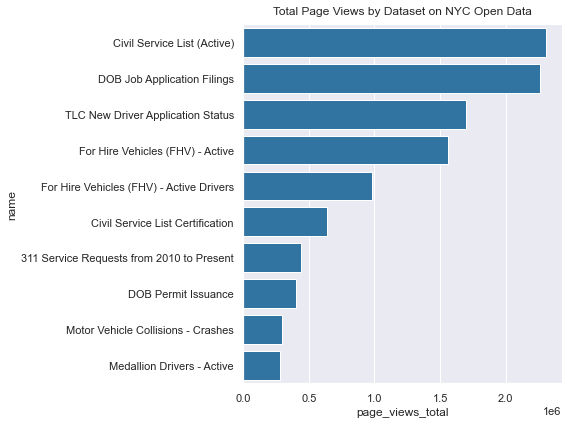

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    df
    .sort_values(by='page_views_total', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='name',
    x='page_views_total',
    color='#1f77b4'
)

plt.title(
    'Total Page Views by Dataset on NYC Open Data',
    fontsize=12, pad=10)
plt.tight_layout()

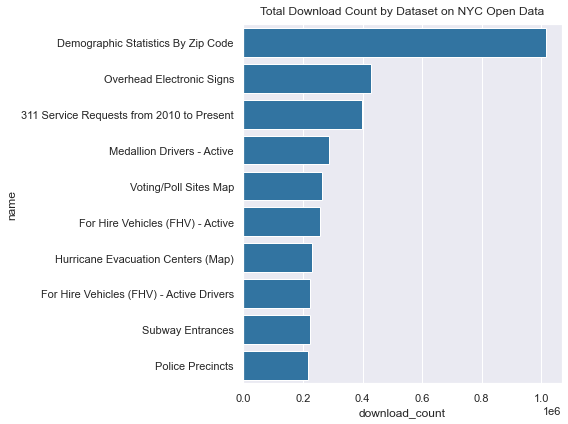

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    df
    .sort_values(by='download_count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='name',
    x='download_count',
    color='#1f77b4'
)

plt.title(
    'Total Download Count by Dataset on NYC Open Data',
    fontsize=12, pad=10
)
plt.tight_layout()

## Analyzing NYC 311 Street Flooding Complaints

### Searching the data set for the word "flood" in the complaint_type field

In [23]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select complaint_type and count of complaint_type grouped by compaint_type,
where the word "flood" is in compplaint_type,
sort count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type, 
    count(unique_key) AS count
WHERE 
    LOWER(complaint_type) LIKE '%flood%'
GROUP BY 
    complaint_type
ORDER BY 
    count(unique_key) DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df

shape of data: (0, 0)


""


### Searching the data set for the word "flood" in the descriptor field

In [24]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select complaint_type and count of complaint_type grouped by compaint_type,
where the word "flood" is in descriptor,
sort count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type,
    descriptor,
    count(unique_key) AS count
WHERE 
    LOWER(descriptor) LIKE '%flood%'
GROUP BY 
    complaint_type, descriptor
ORDER BY 
    count(unique_key) DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df

shape of data: (11, 3)


,complaint_type,descriptor,count
0,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),107858
1,Sewer,Street Flooding (SJ),35901
2,Street Light Condition,Flood Light Lamp Out,6412
3,Sewer,Highway Flooding (SH),3075
4,Street Light Condition,Flood Light Lamp Cycling,2573
5,OEM Literature Request,Ready NY - Flooding,271
6,Street Light Condition,Flood Light Lamp Dayburning,223
7,Street Light Condition,Flood Light Lamp Missing,206
8,Street Light Condition,Flood Light Lamp Dim,184
9,Sewer,RAIN GARDEN FLOODING (SRGFLD),152


### Displaying the highest number of street flooding complaints by day

In [25]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=100
)

""" SoQL query string below:
Select the day and the count day columns grouped by day,
where the descriptor is Street Flooding (SJ),
sort the count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) as day, 
    count(created_date) AS count
WHERE 
    descriptor == 'Street Flooding (SJ)'
GROUP BY 
    day
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (1000, 2)


,day,count
0,2021-09-02T00:00:00.000,350
1,2021-09-01T00:00:00.000,344
2,2022-12-23T00:00:00.000,308
3,2017-05-05T00:00:00.000,247
4,2014-12-09T00:00:00.000,226
5,2014-04-30T00:00:00.000,189
6,2021-10-26T00:00:00.000,177
7,2018-04-16T00:00:00.000,163
8,2013-05-08T00:00:00.000,162
9,2021-08-22T00:00:00.000,158


In [26]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2021-09-02T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (480, 4)


,day,complaint_type,descriptor,count
0,2021-09-02T00:00:00.000,Sewer,Sewer Backup (Use Comments) (SA),2372
1,2021-09-02T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,1350
2,2021-09-02T00:00:00.000,WATER LEAK,HEAVY FLOW,564
3,2021-09-02T00:00:00.000,Traffic Signal Condition,Controller,391
4,2021-09-02T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,358
5,2021-09-02T00:00:00.000,Sewer,Street Flooding (SJ),350
6,2021-09-02T00:00:00.000,PAINT/PLASTER,CEILING,321
7,2021-09-02T00:00:00.000,Blocked Driveway,No Access,313
8,2021-09-02T00:00:00.000,Damaged Tree,Branch or Limb Has Fallen Down,303
9,2021-09-02T00:00:00.000,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),295


In [27]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2022-12-23T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (424, 4)


,day,complaint_type,descriptor,count
0,2022-12-23T00:00:00.000,HEAT/HOT WATER,ENTIRE BUILDING,1524
1,2022-12-23T00:00:00.000,HEAT/HOT WATER,APARTMENT ONLY,870
2,2022-12-23T00:00:00.000,Blocked Driveway,No Access,373
3,2022-12-23T00:00:00.000,Traffic Signal Condition,Controller,322
4,2022-12-23T00:00:00.000,Illegal Parking,Blocked Hydrant,311
5,2022-12-23T00:00:00.000,Sewer,Street Flooding (SJ),308
6,2022-12-23T00:00:00.000,Noise - Residential,Loud Music/Party,250
7,2022-12-23T00:00:00.000,Noise - Residential,Banging/Pounding,210
8,2022-12-23T00:00:00.000,Illegal Parking,Posted Parking Sign Violation,187
9,2022-12-23T00:00:00.000,Damaged Tree,Entire Tree Has Fallen Down,167


### Selecting the rows and columns where the descriptor field = 'Street Flooding'

In [28]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=100
)

""" SoQL query string below:
Select all columns where the descriptor is Street Flooding(SJ),
sort the created date field in descending order and limit our records to 1,000
"""

query = """
SELECT 
    *
WHERE 
    descriptor == 'Street Flooding (SJ)'
ORDER BY 
    created_date DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head()

shape of data: (1000, 30)


,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,intersection_street_1,intersection_street_2,address_type,...,longitude,location,closed_date,incident_address,street_name,cross_street_1,cross_street_2,resolution_description,resolution_action_updated_date,bbl
0,58121474,2023-07-06T21:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11422,147 ROAD,235 STREET,INTERSECTION,...,-73.74636309830915,"{'latitude': '40.65691746118003', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58117188,2023-07-06T09:08:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10473,NaN,NaN,ADDRESS,...,-73.8569801292354,"{'latitude': '40.81204695214478', 'longitude':...",2023-07-06T09:22:00.000,323 BOLTON AVENUE,BOLTON AVENUE,O'BRIEN AVE,SOUNDVIEW AVE,The Department of Environmental Protection has...,2023-07-06T09:22:00.000,2034730052
2,58115638,2023-07-06T08:20:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10310,NaN,NaN,ADDRESS,...,-74.10914010995137,"{'latitude': '40.63931245858667', 'longitude':...",NaN,98 WALNUT STREET,WALNUT STREET,BARD AVE,DAVIS AVE,NaN,NaN,5001380304
3,58112020,2023-07-06T08:02:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11414,NaN,NaN,ADDRESS,...,-73.83039910910065,"{'latitude': '40.651865211045724', 'longitude'...",NaN,99-37 164 AVENUE,164 AVENUE,HAWTREE BASIN SHORELINE,104 ST,NaN,NaN,4142451453
4,58115496,2023-07-06T00:23:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10035,NaN,NaN,ADDRESS,...,-73.93247656540014,"{'latitude': '40.79596866344045', 'longitude':...",2023-07-06T01:34:00.000,324 PLEASANT AVENUE,PLEASANT AVENUE,E 117 ST,E 118 ST,The Department of Environmental Protection det...,2023-07-06T01:34:00.000,1017160051
